In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely
import choroplethNYC as cp
%matplotlib inline
import os

In [2]:
data = pd.read_csv('geo_housing.csv')

In [3]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler  
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

In [4]:
data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'unit', 'status', 'no_rooms', 'no_bath',
       'area(ftsq)', 'id', 'date', 'price', 'bldname', 'address', 'type',
       'top_amenity', 'amenities', 'transp1', 'transp2', 'transp3', 'transp4',
       'transp5', 'units', 'stories', 'year', 'latitude', 'longitude',
       'postcode'],
      dtype='object')

In [5]:
dfs = data[['no_rooms','no_bath','price','latitude','longitude']]

In [6]:
dfs = dfs.convert_objects(convert_numeric=True)

/nfshome/ql459/.conda/envs/myEnv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [7]:
dfs = dfs.dropna(subset=['no_bath'])

In [8]:
dfs.shape

(13608, 5)

### Features Observed

In [9]:
features_df = dfs[['no_rooms','no_bath']]

In [10]:
x = features_df #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [11]:
df.head()

,0,1
0,0.000000,0.043478
1,0.333333,0.043478
2,0.333333,0.043478
3,0.333333,0.043478
4,0.333333,0.043478


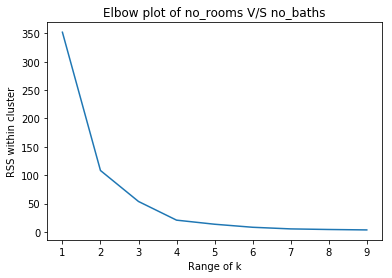

In [12]:
from scipy.spatial.distance import cdist, pdist

k_range = range(1,10)
# Try clustering the data for k values ranging 1 to 10
k_means_var = [KMeans(n_clusters = k).fit(df) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_var]

k_euclid = [cdist(df, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

wcss = [sum(d**2) for d in dist]

import matplotlib.pyplot as plt
plt.plot(k_range, wcss)
plt.xlabel('Range of k')
plt.ylabel('RSS within cluster')
plt.title('Elbow plot of no_rooms V/S no_baths')
plt.show()

### best cluster of 3

In [13]:
kmeans = KMeans(n_clusters=3, random_state=234).fit(df)
labels = kmeans.labels_
df['clusters'] = labels
df2 = df.rename(columns = {0 : 'no_rooms',
                          1 : 'no_bath',
                          2 : 'price'})

In [14]:
df2.head()

,no_rooms,no_bath,clusters
0,0.000000,0.043478,0
1,0.333333,0.043478,1
2,0.333333,0.043478,1
3,0.333333,0.043478,1
4,0.333333,0.043478,1


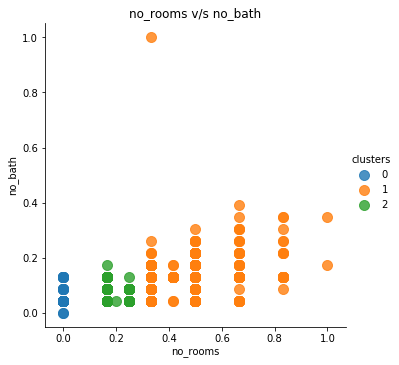

In [15]:
sns.lmplot('no_rooms', 'no_bath', data = df2, fit_reg=False,hue="clusters",  scatter_kws={"marker": "D", "s": 100})
plt.title('no_rooms v/s no_bath')
plt.xlabel('no_rooms')
plt.ylabel('no_bath')
plt.show()

In [16]:
coordination =dfs[['latitude', 'longitude']]

In [17]:
df.head()

,0,1,clusters
0,0.000000,0.043478,0
1,0.333333,0.043478,1
2,0.333333,0.043478,1
3,0.333333,0.043478,1
4,0.333333,0.043478,1


In [18]:
x = coordination #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

[152.7358615252706, 57.725370305829905, 40.554490469240534, 32.84115687154711, 26.667964273634936, 22.5084425485334, 18.193807764956333, 15.203728659251553]


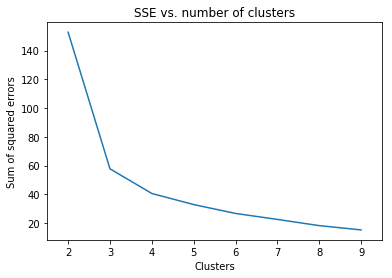

In [19]:
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(df)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.show()

### clusters of 4 is the best

In [20]:
kmeans = KMeans(n_clusters=4, random_state=234).fit(df)
labels = kmeans.labels_
df['clusters'] = labels
df2 = df.rename(columns = {0 : 'latitude',
                          1 : 'longitude'})

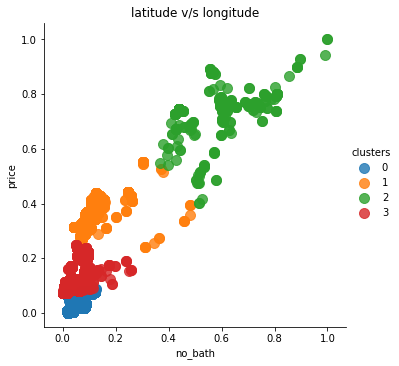

In [21]:
sns.lmplot('latitude', 'longitude', data = df2, fit_reg=False,hue="clusters",  scatter_kws={"marker": "D", "s": 100})
plt.title('latitude v/s longitude')
plt.xlabel('no_bath')
plt.ylabel('price')
plt.show()

### Clustering on Price

In [22]:
temp = dfs[['price']]

In [23]:
x = temp #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [24]:
df.head()

,0
0,0.014773
1,0.113523
2,0.100000
3,0.095455
4,0.125000


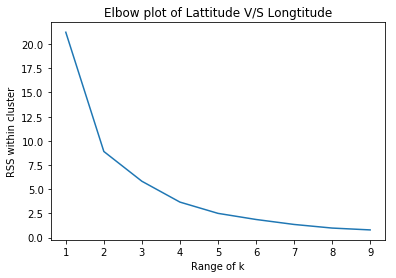

In [25]:
from scipy.spatial.distance import cdist, pdist

k_range = range(1,10)
# Try clustering the data for k values ranging 1 to 10
k_means_var = [KMeans(n_clusters = k).fit(df) for k in k_range]
centroids = [X.cluster_centers_ for X in k_means_var]

k_euclid = [cdist(df, cent, 'euclidean') for cent in centroids]
dist = [np.min(ke, axis=1) for ke in k_euclid]

wcss = [sum(d**2) for d in dist]

import matplotlib.pyplot as plt
plt.plot(k_range, wcss)
plt.xlabel('Range of k')
plt.ylabel('RSS within cluster')
plt.title('Elbow plot of Lattitude V/S Longtitude')
plt.show()

[8.902722350750736, 5.821889967506924, 3.6749872748536077, 2.5061688715128807, 1.875115681065993, 1.364613986058767, 0.9872098751268988, 0.7966269985584457]


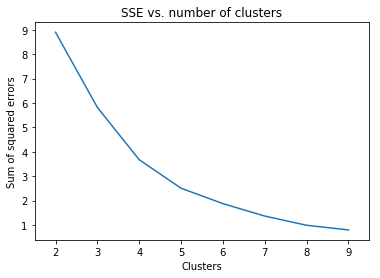

In [26]:
SSE = []
for i in range(2,10):
    km = KMeans(n_clusters = i)
    res=km.fit(df)
    SSE.append(res.inertia_)
print(SSE)

plt.gca()
plt.plot(range(2,10),SSE)
plt.xlabel("Clusters")
plt.ylabel("Sum of squared errors")
plt.title("SSE vs. number of clusters")
plt.xlim(1.5,9.5)
plt.show()

In [27]:
kmeans = KMeans(n_clusters=3, random_state=234).fit(df)
labels = kmeans.labels_
df['clusters'] = labels
#df2 = df.rename(columns = {0 : 'no_rooms',
#                          1 : 'no_bath',
#                          2 : 'price'})
df2 = df.rename(columns = {0 : 'price'})

In [28]:
#dfs
dfs['clusters'] = labels

In [29]:
dfs.head()

,no_rooms,no_bath,price,latitude,longitude,clusters
0,0.0,1.0,1650.0,40.775707,-73.957205,0
1,2.0,1.0,5995.0,40.727683,-73.981419,2
2,2.0,1.0,5400.0,40.727683,-73.981419,2
3,2.0,1.0,5200.0,40.727683,-73.981419,2
4,2.0,1.0,6500.0,40.727683,-73.981419,1


In [30]:
newDf = dfs[['no_rooms','no_bath','price','latitude','longitude','clusters']]

In [31]:
newDf['lonlat'] = list(zip(newDf.longitude, newDf.latitude))
#generate a "geometry" column
newDf['geometry'] = newDf[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [32]:
geo_df = gpd.GeoDataFrame(newDf, geometry='geometry')

In [33]:
geo_df.crs = {'init': 'epsg:4326'}

In [34]:
geo_df.head()

,no_rooms,no_bath,price,latitude,longitude,clusters,lonlat,geometry
0,0.0,1.0,1650.0,40.775707,-73.957205,0,"(-73.95720500000002, 40.775707)",POINT (-73.95720500000002 40.775707)
1,2.0,1.0,5995.0,40.727683,-73.981419,2,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)
2,2.0,1.0,5400.0,40.727683,-73.981419,2,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)
3,2.0,1.0,5200.0,40.727683,-73.981419,2,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)
4,2.0,1.0,6500.0,40.727683,-73.981419,1,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)


/nfshome/ql459/.conda/envs/myEnv/lib/python3.6/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


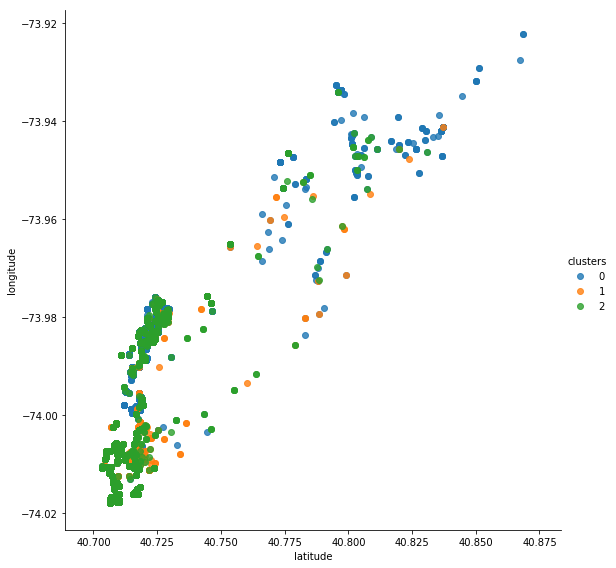

In [35]:
sns.lmplot(data=geo_df, x='latitude',y='longitude', hue='clusters',
          fit_reg=False, legend=True, legend_out=True, size=8)



In [43]:
pumashp = gpd.GeoDataFrame.from_file("geo_export_92ed6625-22aa-40bd-85e1-92aea9f80c48.shp")

In [44]:
pumashp.puma = pd.to_numeric(pumashp.puma)

In [45]:
puma = pumashp[(pumashp.puma > 3800)&(pumashp.puma < 3811)].reset_index(drop=True)

In [46]:
neighbor = ['Washington Heights - Inwood',
           'Central Harlem - Morningside Heights',
           'East Harlem',
           'Upper West Side',
           'Upper East Side',
           'Chelsea - Clinton',
           'Gramercy Park - Murray Hill',
           'Greenwich Village - Soho',
           'Union Square - Lower East Side',
           'Lower Manhattan']

In [47]:
puma['neighborhood'] = neighbor

In [48]:
puma

,puma,shape_area,shape_leng,geometry,neighborhood
0,3801,8.124958e+07,64103.138480,(POLYGON ((-73.92640556921116 40.8776214765373...,Washington Heights - Inwood
1,3802,4.689908e+07,37925.566208,POLYGON ((-73.96909103244369 40.80843016507839...,Central Harlem - Morningside Heights
2,3803,3.984279e+07,38064.749400,POLYGON ((-73.93515659173335 40.83268240673983...,East Harlem
3,3804,6.461212e+07,62599.500502,(POLYGON ((-73.92133752419279 40.8008521075021...,Upper West Side
4,3805,5.516881e+07,53561.096534,(POLYGON ((-73.95037548074407 40.7631738455804...,Upper East Side
5,3806,8.849786e+07,47538.426032,"POLYGON ((-73.96147779967508 40.7986541564366,...",Chelsea - Clinton
6,3807,8.560261e+07,72181.026886,POLYGON ((-73.99667705784741 40.77351005394218...,Gramercy Park - Murray Hill
7,3808,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616142...,Greenwich Village - Soho
8,3809,4.869347e+07,35299.804402,(POLYGON ((-73.98237340572007 40.7055433504376...,Union Square - Lower East Side
9,3810,8.104639e+07,122921.903883,(POLYGON ((-74.01092841268031 40.6844914725429...,Lower Manhattan


In [49]:
cluster0 = geo_df[geo_df["clusters"]==0]
cluster1 = geo_df[geo_df["clusters"]==1]
cluster2 = geo_df[geo_df["clusters"]==2]

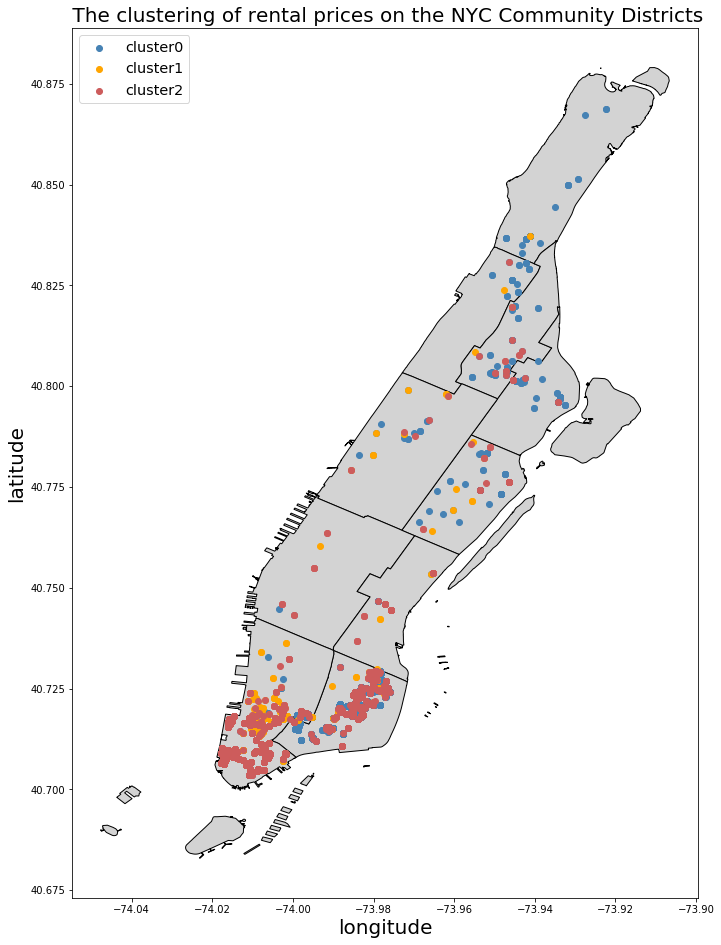

In [50]:
ax = puma.plot(figsize=(16,16), color='lightgrey', edgecolor = 'black')
cluster0.plot(column=None, color='steelblue',ax=ax, label='cluster0')
cluster1.plot(column=None, color='orange',ax=ax, label='cluster1')
cluster2.plot(column=None, color='IndianRed',ax=ax, label='cluster2')
ax.set_title(" The clustering of rental prices on the NYC Community Districts", fontsize=20)
ax.set_ylabel("latitude", fontsize=20)
ax.set_xlabel("longitude", fontsize=20)
ax.legend(loc='upper left', fontsize='x-large')

In [51]:
geo_df[geo_df["clusters"] ==0].price.describe()

count    7757.000000
mean     2965.031069
std       521.659333
min      1000.000000
25%      2580.000000
50%      3000.000000
75%      3395.000000
max      3848.000000
Name: price, dtype: float64

In [52]:
geo_df[geo_df["clusters"] ==1].price.describe()

count     1371.000000
mean      7750.280088
std       2294.312199
min       6245.000000
25%       6722.500000
50%       7255.000000
75%       8062.500000
max      45000.000000
Name: price, dtype: float64

In [53]:
geo_df[geo_df["clusters"] ==2].price.describe()

count    4480.000000
mean     4705.575670
std       659.751339
min      3850.000000
25%      4140.000000
50%      4500.000000
75%      5200.000000
max      6225.000000
Name: price, dtype: float64

In [54]:
geo_df.head()

,no_rooms,no_bath,price,latitude,longitude,clusters,lonlat,geometry
0,0.0,1.0,1650.0,40.775707,-73.957205,0,"(-73.95720500000002, 40.775707)",POINT (-73.95720500000002 40.775707)
1,2.0,1.0,5995.0,40.727683,-73.981419,2,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)
2,2.0,1.0,5400.0,40.727683,-73.981419,2,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)
3,2.0,1.0,5200.0,40.727683,-73.981419,2,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)
4,2.0,1.0,6500.0,40.727683,-73.981419,1,"(-73.98141919999998, 40.7276833)",POINT (-73.98141919999998 40.7276833)


In [55]:
geo_df[['no_rooms','clusters']].groupby(['clusters','no_rooms']).count()

Empty DataFrame
Columns: []
Index: [(0, 0.0), (0, 1.0), (0, 1.5), (0, 2.0), (0, 2.5), (0, 3.0), (0, 4.0), (1, 0.0), (1, 1.0), (1, 1.5), (1, 2.0), (1, 2.5), (1, 3.0), (1, 4.0), (1, 5.0), (1, 6.0), (2, 0.0), (2, 1.0), (2, 1.2), (2, 1.5), (2, 2.0), (2, 2.5), (2, 3.0), (2, 4.0), (2, 5.0)]

In [56]:
geo_df[['no_rooms','clusters','price']].groupby(['clusters','no_rooms']).count()

price
clusters no_rooms       
0        0.0        2832
         1.0        3514
         1.5           7
         2.0        1198
         2.5           1
         3.0         200
         4.0           5
1        0.0          18
         1.0          82
         1.5           2
         2.0         850
         2.5          36
         3.0         314
         4.0          42
         5.0          25
         6.0           2
2        0.0         179
         1.0        1842
         1.2           1
         1.5          46
         2.0        1769
         2.5           8
         3.0         577
         4.0          56
         5.0           2